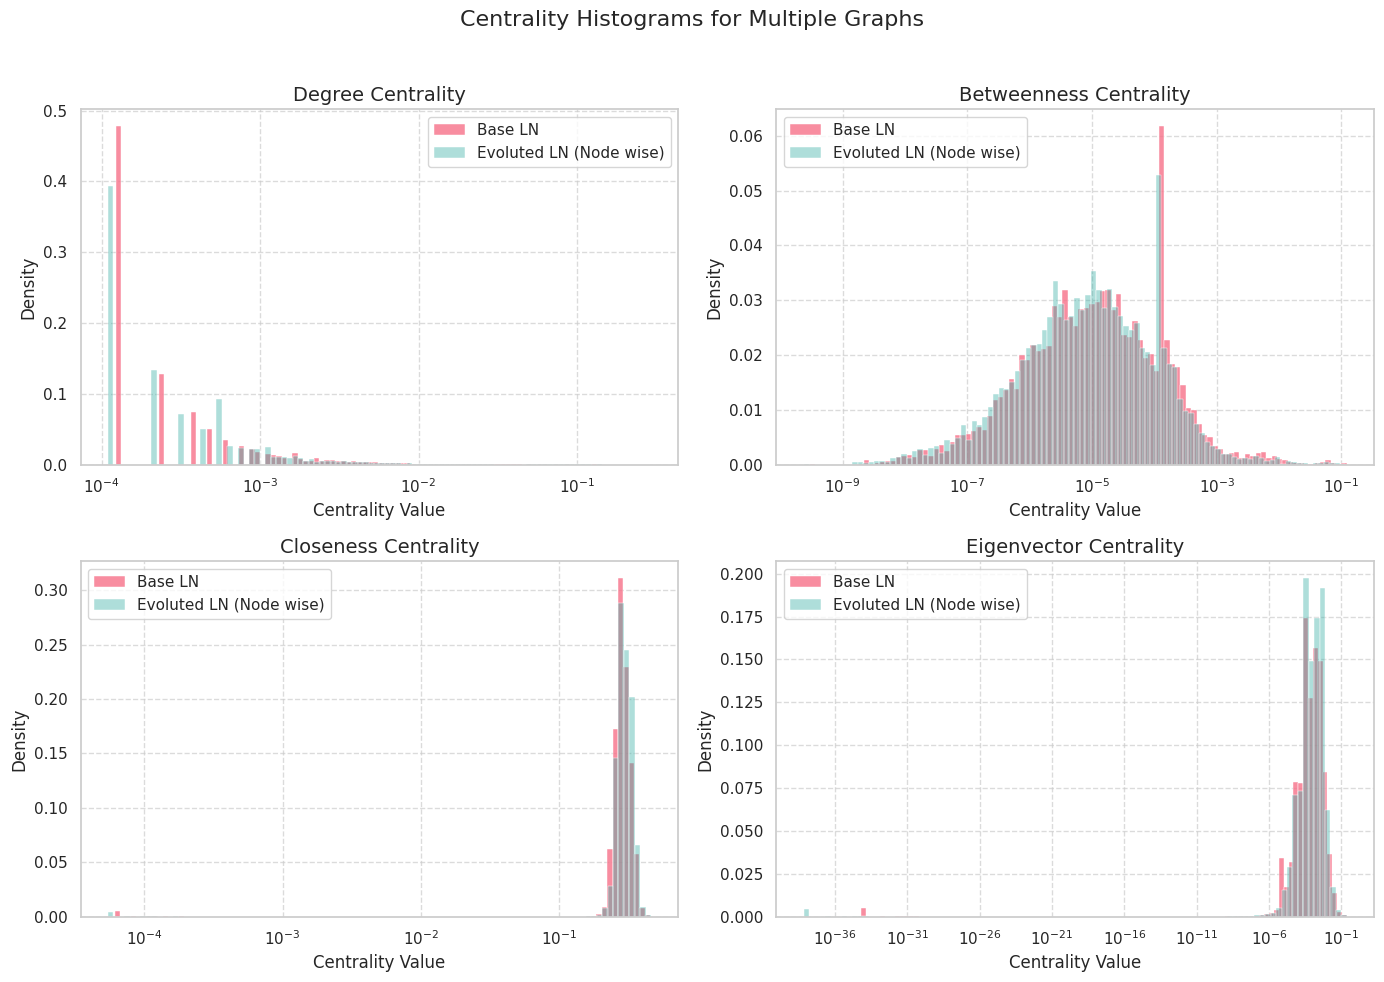

In [6]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.preprocessing import normalize
import pickle
# Function to load centralities from a file
def load_centralities(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Function to calculate entropy of a centrality vector
def calculate_entropy(centrality):
    normalized_centrality = normalize(centrality.reshape(1, -1), norm='l1')[0]
    return entropy(normalized_centrality)

# Function to calculate Gini coefficient
def calculate_gini(centrality):
    sorted_centrality = np.sort(centrality)
    n = len(centrality)
    cumulative_centrality = np.cumsum(sorted_centrality)
    gini_coefficient = (n + 1 - 2 * np.sum(cumulative_centrality) / cumulative_centrality[-1]) / n
    return gini_coefficient

# Function to calculate diversity index (Simpson's Index)
def calculate_diversity_index(centrality):
    normalized_centrality = normalize(centrality.reshape(1, -1), norm='l1')[0]
    return 1 - np.sum(np.square(normalized_centrality))

def calculate_renyi_entropy(centrality, alpha):
    if alpha < 0:
        raise ValueError("Alpha must be non-negative.")
    if alpha == 1:
        raise ValueError("Alpha should not be equal to 1. Use Shannon entropy instead.")

    # Normalize the centrality values to get a probability distribution
    normalized_centrality = normalize(centrality.reshape(1, -1), norm='l1')[0]

    if alpha == 0:
        # For alpha = 0, Rényi entropy corresponds to the log of the number of non-zero elements
        renyi_entropy = np.log(np.count_nonzero(normalized_centrality))
    else:
        # Calculate the sum of the probabilities raised to the power of alpha
        centrality_sum = np.sum(np.power(normalized_centrality, alpha))

        # Calculate Rényi entropy
        renyi_entropy = (1 / (1 - alpha)) * np.log(centrality_sum)

    return renyi_entropy



# Function to plot combined histograms using Seaborn
def plot_combined_histograms(centralities_dict, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 10))
    colors = sns.color_palette("husl", len(centralities_dict))  # Professional color palette

    for i, (graph_name, centralities) in enumerate(centralities_dict.items()):
        for j, (centrality_name, centrality_values) in enumerate(centralities.items()):
            plt.subplot(2, 2, j+1)
            sns.histplot(centrality_values, bins=100, kde=False, color=colors[i],
                         label=graph_name, stat="probability", alpha=(2-i)*0.4, log_scale=True)

            plt.title(f'{centrality_name.capitalize()} Centrality', fontsize=14)
            plt.xlabel('Centrality Value', fontsize=12)
            plt.ylabel('Density', fontsize=12)
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
    plt.show()


filenames = ["base_ln_centralities.pkl", "centralities_LN_2000.pkl"]
graphs = ["Base LN", "Evoluted LN (Node wise)"]

centralities_dict = {}

for i, filename in enumerate(filenames):
    centralities = load_centralities(filename)
    centralities_dict[graphs[i]] = centralities

# Plot combined histograms
plot_combined_histograms(centralities_dict, "Centrality Histograms for Multiple Graphs")

# Calculate and print entropy, Gini coefficient, and diversity index for each centrality
results = []
deltas = []

# Base LN centralities for comparison
base_centralities = centralities_dict["Base LN"]

for graph_name, centralities in centralities_dict.items():
    results.append(f"{graph_name} Centrality Analysis:")
    if graph_name != "Base LN":
        deltas.append(f"Delta for {graph_name} Centrality Analysis from Base LN:")

    for centrality_name, centrality_values in centralities.items():
        entropy_value = calculate_entropy(centrality_values)
        renyi_entropy_value = calculate_renyi_entropy(centrality_values, 2)
        gini_value = calculate_gini(centrality_values)
        diversity_value = calculate_diversity_index(centrality_values)

        results.append(f"{centrality_name.capitalize()} Centrality:")
        results.append(f"  Entropy: {entropy_value:.4f}")
        results.append(f"  Renyi Entropy: {renyi_entropy_value:.4f}")
        results.append(f"  Gini Coefficient: {gini_value:.4f}")
        results.append(f"  Diversity Index: {diversity_value:.4f}")
        results.append("-" * 40)

        if graph_name != "Base LN":
            # Calculate deltas
            delta_entropy = entropy_value - calculate_entropy(base_centralities[centrality_name])
            delta_renyi_entropy = renyi_entropy_value - calculate_renyi_entropy(base_centralities[centrality_name], 2)
            delta_gini = gini_value - calculate_gini(base_centralities[centrality_name])
            delta_diversity = diversity_value - calculate_diversity_index(base_centralities[centrality_name])

            deltas.append(f"{centrality_name.capitalize()} Centrality:")
            deltas.append(f"  Delta Entropy: {delta_entropy:.4f}")
            deltas.append(f"  Delta Renyi Entropy: {delta_renyi_entropy:.4f}")
            deltas.append(f"  Delta Gini Coefficient: {delta_gini:.4f}")
            deltas.append(f"  Delta Diversity Index: {delta_diversity:.4f}")
            deltas.append("-" * 40)

    results.append("=" * 50)
    if graph_name != "Base LN":
        deltas.append("=" * 50)

# Save the results to a text file
with open("centrality_analysis_results.txt", "w") as f:
    for line in results:
        f.write(line + "\n")

# Save the deltas to a separate text file
with open("centrality_deltas.txt", "w") as f:
    for line in deltas:
        f.write(line + "\n")

# Print the results in the console
for line in results:
    print(line)

# Print the deltas in the console
for line in deltas:
    print(line)


In [ ]:
import networkx as nx
import pickle
import community.community_louvain as community_louvain

# Function to load a graph from a pickle file and convert it to an undirected graph
def load_and_convert_to_undirected(filename):
    with open(filename, 'rb') as f:
        G = pickle.load(f)
    return G.to_undirected()

# Function to calculate modularity of a graph
def calculate_modularity(G):
    partition = community_louvain.best_partition(G)
    return community_louvain.modularity(partition, G)

# List of pickle filenames for the four graphs
filenames = ["base_LN.pkl", "evoluted_ln_2000.pkl"]
graph_names = ["Base LN", "Evoluted LN (Node wise)"]

# Dictionary to store modularity results
modularity_results = {}

# Load each graph, convert to undirected, and calculate modularity
for i, filename in enumerate(filenames):
    G = load_and_convert_to_undirected(filename)
    modularity = calculate_modularity(G)
    modularity_results[graph_names[i]] = modularity
    print(f"Modularity of {graph_names[i]}: {modularity:.4f}")

# Optional: Save the modularity results to a file for later reference
with open("modularity_results.txt", "w") as f:
    for graph_name, modularity in modularity_results.items():
        f.write(f"Modularity of {graph_name}: {modularity:.4f}\n")
